In [1]:
# Original Source : https://github.com/alod83/data-science/blob/master/DataAnalysis/\BreakpointAnalysis

# Breakpoints Analysis

When dealing with time series, it is very important to identify breakpoints. In fact, the presence of breakpoints in data may lead to errors and model instability while performing predictions. 

A breakpoint is a structural change in data, such as an anomaly or an expected event. 

Many techniques exist to identify breakpoints. In general, these techniques can be classified into two categories: 
* detection - detect one or many breakpoints
* test - given a point, check whether it is a breakpoint or not. This category of techniques includes the famous [Chow Test](https://en.wikipedia.org/wiki/Chow_test).

In this short tutorial, I focus on the first category of breakpoints and I compare two Python libraries for breakpoints analysis: `ruptures` and `jenkspy`.

## Load data
Firstly I load the dataset as a `pandas` dataframe. As dataset I exploit the [Giallozafferano](https://www.giallozafferano.com/) audience trend from 2015 to 2020. Giallozafferano is a very famous Italian food blog. Data have been extracted from [Audiweb](http://www.audiweb.it/), an Italian Web site which analyses the use of Internet in Italy, and, then elaborated through a software implemented by one of my students, called [LEX](https://github.com/Alearena97/LEX---Lettore-ed-Estrattore_xls-xlsx). LEX is a very useful software which converts multiple files in Microsoft Excel, divided by dates, to a single CSV file. If you want to know more about this software, please drop me a message :)

In [2]:
import pandas as pd

df = pd.read_csv('data/breakpoint_tsa/GialloZafferano.csv')
df.head()

,date,audience
0,2015-1-01,750823.0
1,2015-2-01,823766.0
2,2015-3-01,736273.0
3,2015-4-01,663810.0
4,2015-5-01,558158.0


Now I convert the dataframe into a time series. This can be done in three steps:
* convert the `data` field to a datetime 
* set the date column as index of the time series
* assign the column of values to a new variable, called `ts`.

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace = True)
ts = df['audience']

I plot the time series. I exploit the `matplotlib` library.

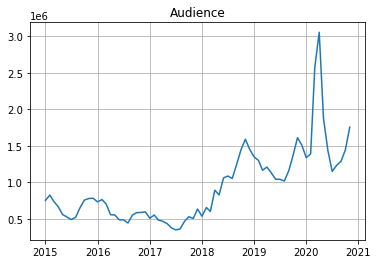

In [4]:
import matplotlib.pyplot as plt

plt.plot(ts)
plt.title('Audience')
plt.grid()
plt.show()

Looking at the graph, I note that the are about three main breaks. Thus, I decide to search for 3 breaks.

In [5]:
n_breaks = 3

I prepare data to be given as input of the tested libraries. I convert the time series to array.

In [6]:
import numpy as np

y = np.array(ts.tolist())

# Ruptures

The first breakpoints detection library is [Ruptures](https://pypi.org/project/ruptures/), which can be installed through the command `pip install rupture`. 

Ruptures provides six different models to detect breakpoints: `Dynp`, `KernelCPD`, `Pelt`, `Binseg`, `BottomUp`, `Window`. Each model must be built, trained (through the `fit()` function) and then used for prediction. The `predict()` function receives as input the number of breakpoints (minus 1) to be identified. 

In [7]:
import ruptures as rpt

model = rpt.Dynp(model="l1")
model.fit(y)
breaks = model.predict(n_bkps=n_breaks-1)

Since `ruptures` returns the index at which the structural change happens, I retrieve the date from the original time series `ts`.

In [8]:
breaks_rpt = []
for i in breaks:
    breaks_rpt.append(ts.index[i-1])
breaks_rpt = pd.to_datetime(breaks_rpt)
breaks_rpt

DatetimeIndex(['2016-03-01', '2018-04-01', '2020-11-01'], dtype='datetime64[ns]', freq=None)

Now I plot results.

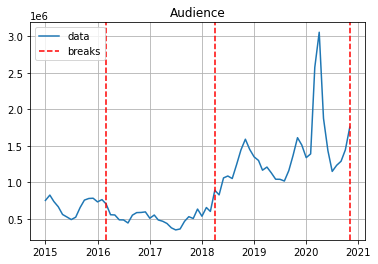

In [9]:
plt.plot(ts, label='data')
plt.title('Audience')
print_legend = True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')
plt.grid()
plt.legend()
plt.show()

# Jenkspy
The second breakpoints detection library is [Jenkspy](https://pypi.org/project/jenkspy/), which can be installed through the following command: `pip install jenkspy`. This library computes the natural breaks into an array according to the Fisher-Jenks algorithm.

I import the library (`import jenkspy`) and then I call the `jenks_breaks()` function, which receives the arrary of values and the number of breaks to be detected as input. As output, the function returns the values corresponding to the identified breaks. Remind that Ruptures, instead, returns the breaks indexes. 

In [10]:
import jenkspy

breaks = jenkspy.jenks_breaks(y, nb_class=n_breaks-1)

I calculate the breaks indexes, by looping through the `breaks` array.

In [11]:
breaks_jkp = []
for v in breaks:
    idx = ts.index[ts == v]
    breaks_jkp.append(idx)
breaks_jkp

[DatetimeIndex(['2017-07-01'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2018-04-01'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2020-04-01'], dtype='datetime64[ns]', name='date', freq=None)]

And I plot results.

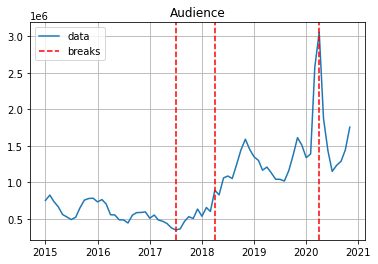

In [12]:
plt.plot(ts, label='data')
plt.title('Audience')
print_legend = True
for i in breaks_jkp:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')
plt.grid()
plt.legend()
plt.show()

# Compare results
Finally, I compare the results produced by the two libraries. I perform a visual comparison. 

I calculate the ideal case, where both the algorithms produce the same result.

In [13]:
x_ideal = ts.index
y_ideal = x_ideal

I compare the two algorithms through a scatter plot. The ideal case is plotted in red.
I note that there is only a common break (the one crossing the ideal case). The first breakpoint is quite different,while the third one is quite similar.

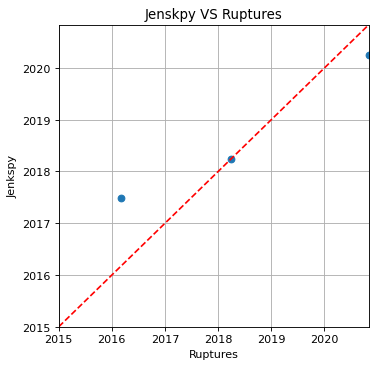

In [14]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(breaks_rpt,breaks_jkp)
plt.xlabel('Ruptures')
plt.ylabel('Jenkspy')
plt.title('Jenskpy VS Ruptures')
plt.xlim(ts.index[0], ts.index[len(ts)-1])
plt.ylim(ts.index[0], ts.index[len(ts)-1])
plt.plot(x_ideal,y_ideal, color='r', linestyle='dashed')
plt.grid()
plt.show()